In [175]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
import os
import glob
from skimage.filters import gaussian
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from pandas import DataFrame

sys.path.append(r"D:\Projects\LEGO Vision\Helpers")
import helpers

In [148]:
image = cv2.imread(r"C:\Users\Thijs\Google Drive\LEGO Vision\Unprocessed Images\IMG_20181023_102539.jpg")

In [141]:
image = cv2.imread(r"C:\Users\Thijs\Google Drive\LEGO Vision\Unprocessed Images\IMG_20181023_102426.jpg")

In [150]:
image = cv2.resize(image, (256, 256))

c:\users\thijs\appdata\local\programs\python\python36\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


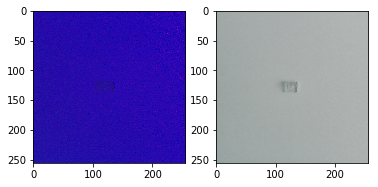

In [155]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
axes[1].imshow(gaussian(image, sigma=0.5))

In [220]:
def hoggify_with_opencv(image, shape):
    image = cv2.GaussianBlur(image, (0, 0), 5)
    return np.squeeze(helpers.hog_descriptor_opencv(image, shape=shape))


def hoggify_with_skimage(image, shape, visualize=False):
    image = gaussian(image, sigma=0.5)
    hog_descriptor = hog(image, pixels_per_cell=(shape[0] / 4, shape[0] / 4), cells_per_block=(4, 4), block_norm="L2-Hys",
                         visualize=visualize)
    if visualize:
        plt.imshow(hog_descriptor[-1])
        return hog_descriptor[0]
    else:
        return hog_descriptor
    
def cannify_with_opencv(image, visualize=False):
    edges = cv2.Canny(image,10,100)
    if visualize:
        plt.imshow(edges, cmap=plt.cm.gray)
    return edges.flatten()

In [221]:
def pipeline(image, **kwargs):
    return cannify_with_opencv(image, **kwargs)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


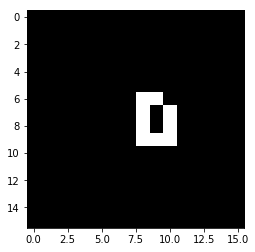

In [225]:
shape = (16, 16)
negative_image_dir = r"D:\LEGO Vision Datasets\Positive and Negative Samples for Linear SVM\neg"
positive_image_dir = r"D:\LEGO Vision Datasets\classification-natural-data"
X = []
y = []
positive_sample_count = 0
for _class in list(os.walk(positive_image_dir))[0][1]:
    for file in glob.glob(os.path.join(positive_image_dir, _class, '*.jpg'))[:200]:       
        positive_sample_count += 1
        visualize=False
        if positive_sample_count % 100 == 0:
            print(positive_sample_count)
            visualize=True
        image = cv2.resize(cv2.imread(file, 0), shape)
        X.append(pipeline(image, visualize=visualize))
        y.append(1)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


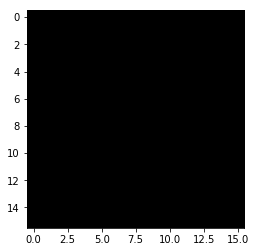

In [226]:
negative_descriptors = []
for negative_sample in os.listdir(negative_image_dir)[:200]:
    image = cv2.resize(cv2.imread(os.path.join(negative_image_dir, negative_sample), 0), shape)
    descriptor = pipeline(image, visualize=True)
    negative_descriptors.append(descriptor)
negative_sample_count = 0
for negative_sample in negative_descriptors * int(positive_sample_count / 200):
    X.append(negative_sample)
    y.append(0)
    negative_sample_count += 1
    if negative_sample_count % 100 == 0:
        print(negative_sample_count)
    

In [227]:
X = np.array(X)
y = np.array(y)
X.shape

(2800, 256)

In [228]:
svm = LinearSVC()
svm.fit(X,y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [229]:
parameters = {'C':[1, 10, 100, 1000]}
svc = SVC(gamma="scale")
clf = GridSearchCV(LinearSVC(max_iter=100000), parameters, cv=KFold(n_splits=3), return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [247]:
parameters = {'kernel': ['linear', 'rbf'], 'C':[1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001]}
clf = GridSearchCV(SVC(), parameters, cv=KFold(n_splits=3), return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['linear', 'rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [248]:
DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.023658,0.007714,0.011655,0.004021,1,0.1,linear,"{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}",0.974304,0.997856,1.0,0.990714,0.011643,17,0.999464,0.989823,0.989288,0.992858,0.004676
1,0.435745,0.163652,0.207885,0.077144,1,0.1,rbf,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.979657,0.998928,1.0,0.992857,0.009349,1,0.999464,0.989823,0.989288,0.992858,0.004676
2,0.022326,0.007319,0.010655,0.003392,1,0.01,linear,"{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}",0.974304,0.997856,1.0,0.990714,0.011643,17,0.999464,0.989823,0.989288,0.992858,0.004676
3,0.430127,0.164349,0.206648,0.080197,1,0.01,rbf,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.979657,0.998928,1.0,0.992857,0.009349,1,0.999464,0.989823,0.989288,0.992858,0.004676
4,0.022320,0.007314,0.010661,0.003298,1,0.001,linear,"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",0.974304,0.997856,1.0,0.990714,0.011643,17,0.999464,0.989823,0.989288,0.992858,0.004676
5,0.429593,0.171630,0.208240,0.082129,1,0.001,rbf,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.979657,0.998928,1.0,0.992857,0.009349,1,0.999464,0.989823,0.989288,0.992858,0.004676
6,0.023006,0.007104,0.010667,0.003314,1,0.0001,linear,"{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}",0.974304,0.997856,1.0,0.990714,0.011643,17,0.999464,0.989823,0.989288,0.992858,0.004676
7,0.401885,0.146491,0.181229,0.068742,1,0.0001,rbf,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.979657,0.998928,1.0,0.992857,0.009349,1,0.999464,0.989823,0.989288,0.992858,0.004676
8,0.022654,0.006844,0.010327,0.003857,10,0.1,linear,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}",0.974304,0.997856,1.0,0.990714,0.011643,17,0.999464,0.989823,0.989288,0.992858,0.004676
9,0.424130,0.166514,0.204873,0.079806,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.979657,0.998928,1.0,0.992857,0.009349,1,0.999464,0.989823,0.989288,0.992858,0.004676


In [249]:
clf.best_estimator_ 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [236]:
image = cv2.resize(cv2.imread(r"C:\Users\Thijs\Google Drive\LEGO Vision\Unprocessed Images\IMG_20181023_102539-background.jpg", 0), shape)

array([0])

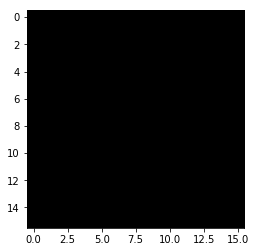

In [237]:
descriptor = pipeline(image, visualize=True)
clf.predict([descriptor])

16


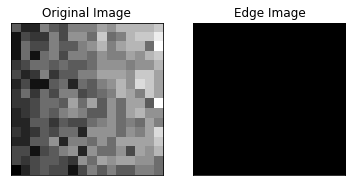

In [244]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
 
img = image
edges = cv2.Canny(img,10,200)
print(len(edges))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()